# Fake news detection

We are going to attempt to label articles as either being real or fake.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from IPython.display import display, Markdown
import pandas as pd

def head(df: pd.DataFrame, n_rows:int=1) -> None:
    """
    Pretty-print the head of a Pandas table in a Jupyter notebook and show its dimensions.
    
    credit: https://gist.github.com/dmyersturnbull/035876942070ced4c565e4e96161be3e
    """
    display(Markdown("**whole table (below):** {} rows × {} columns".format(len(df), len(df.columns))))
    display(df.head(n_rows))

[nltk_data] Downloading package punkt to /home/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/evan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectorization

As data we are going to use the text of each article, but first we need to convert it to a form appropriate for our models to train and predict on.. Vectors!
We are going to use tfidf vectors (Term frequency, Inverted Document Frequency).
Before vectorizing we are also going to remove stopwords from the text.

Also note that we are splitting our data into train(80%) and test(20%) sets.

In [2]:
# import boilerplate
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from string import punctuation

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

print("Loading from file..")
# load data from file
# df = pd.read_csv("fake_or_real_news.csv")#, nrows=n)
df = pd.read_csv("train.csv", nrows = 10_000)

# show data
head(df, n_rows=10)

# split data into test and train tests
x_train, x_test, y_train, y_test = train_test_split(df["title"], df["label"], test_size=0.2, shuffle=True)

# vectorize data
vectorizer = TfidfVectorizer(use_idf=True, stop_words = stopwords.words("english"))
print("Vectorizing..", end="")
x_train_tfidf = vectorizer.fit_transform(x_train.astype('U').values)
print("..")
x_test_tfidf = vectorizer.transform(x_test.astype('U').values)
print("done")

Loading from file..


**whole table (below):** 10000 rows × 5 columns

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


Vectorizing....
done


## Train a model

We are going to train several models so we can later compare them.

* SVC (also known as SVM, support vector machines)
* Descision Tree
* Perceptron (the grandfather of modern neural nets)
* Bernoulli Naive Bayes (Naive Bayes with binary features)

In [3]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB

# r_r: reproducible_results
# set to 0 to initialize deterministically
# set to None to intialize randomly
r_r = 0

models = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=r_r),
    "Perceptron": Perceptron(random_state=r_r),
    "Bernoulli Naive Bayes": BernoulliNB(),
}

trained_models = dict()

print("Training models..")
for name, model in models.items():
    print(f"\tTraining {name}..", end="")
    trained_models[name] = model.fit(x_train_tfidf, y_train)
    print(".")

print("done")

Training models..
	Training SVM...
	Training Decision Tree...
	Training Perceptron...
	Training Bernoulli Naive Bayes...
done


## Intermission

We can also attempt to plot the decission tree generated by our Decission Tree Classifier!

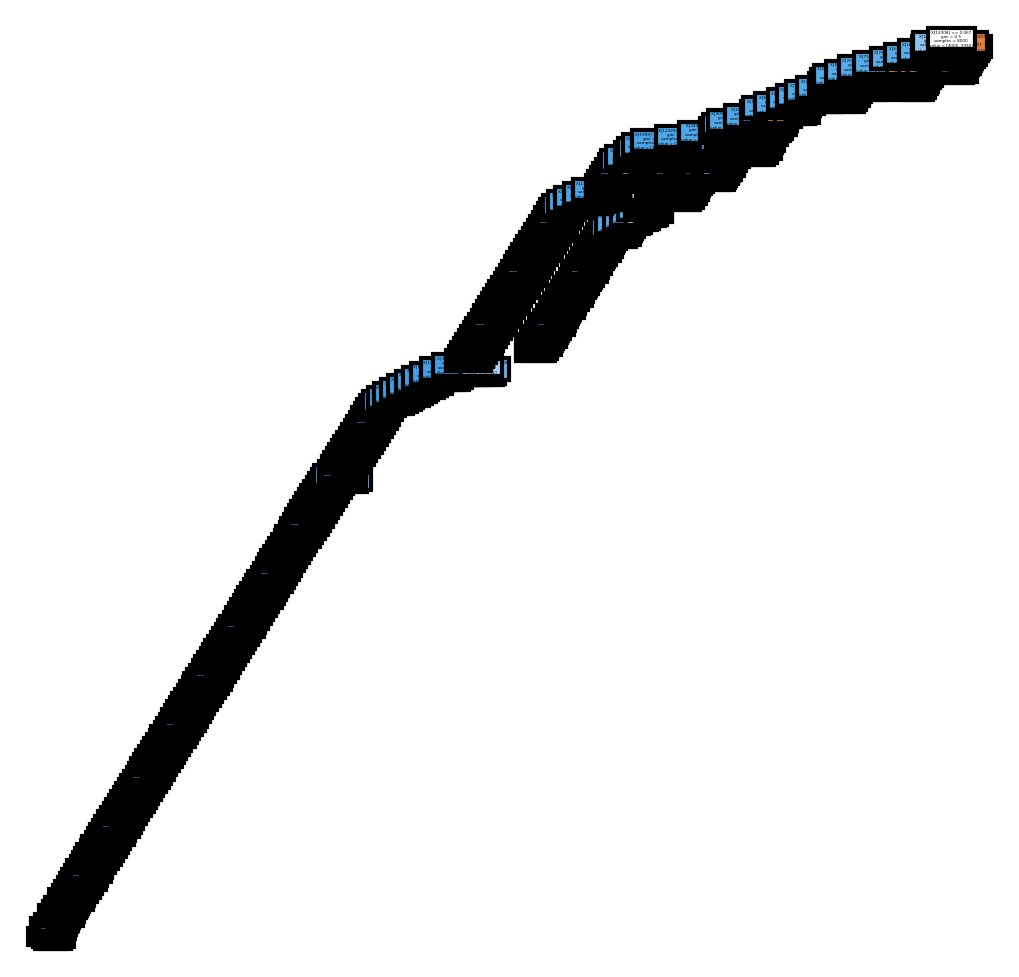

In [4]:
from sklearn import tree
clf = trained_models["Decision Tree"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

tree.plot_tree(clf, filled = True);

### That didn't go too well..

anyway, moving on..

## Using the models

Here we use the models on our test set and calculate various scores.

* Accuracy: $\frac{\textrm{Positive}}{\textrm{Total Samples}}$
* Precision: $\frac{\textrm{True Positive}}{\textrm{True Positive} + \textrm{False Positive}}$
* Recall: $\frac{\textrm{True Positive}}{\textrm{True Positive} + \textrm{False Negative}}$
* F1 score: $2 \cdot \frac{\textrm{Precision} \cdot \textrm{Recall}}{\textrm{Precision} + \textrm{Recall}}$

F1 score is also known as F1 measure.

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

results = dict()
print("Predicting...")

for name, model in trained_models.items():
    print(f"with {name}..", end = "")
    # predict
    y_pred = model.predict(x_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "accuracy": acc,
        "precision": pre,
        "recall": rec,
        "f1": f1,
    }
    print(".")
    print(f"\tAccuracy score: {acc}")
    print(f"\tPrecision score: {pre}")
    print(f"\tRecall score: {rec}")
    print(f"\tF1 score: {rec}")



Predicting...
with SVM...
	Accuracy score: 0.926
	Precision score: 0.8760907504363001
	Recall score: 0.994059405940594
	F1 score: 0.994059405940594
with Decision Tree...
	Accuracy score: 0.9165
	Precision score: 0.9041227229146692
	Recall score: 0.9336633663366337
	F1 score: 0.9336633663366337
with Perceptron...
	Accuracy score: 0.9155
	Precision score: 0.9102439024390244
	Recall score: 0.9237623762376238
	F1 score: 0.9237623762376238
with Bernoulli Naive Bayes...
	Accuracy score: 0.9255
	Precision score: 0.9042253521126761
	Recall score: 0.9534653465346534
	F1 score: 0.9534653465346534


## Now we plot the results

We use a logarithmic y-axis because the results are too similar to view with normal axis scaling.

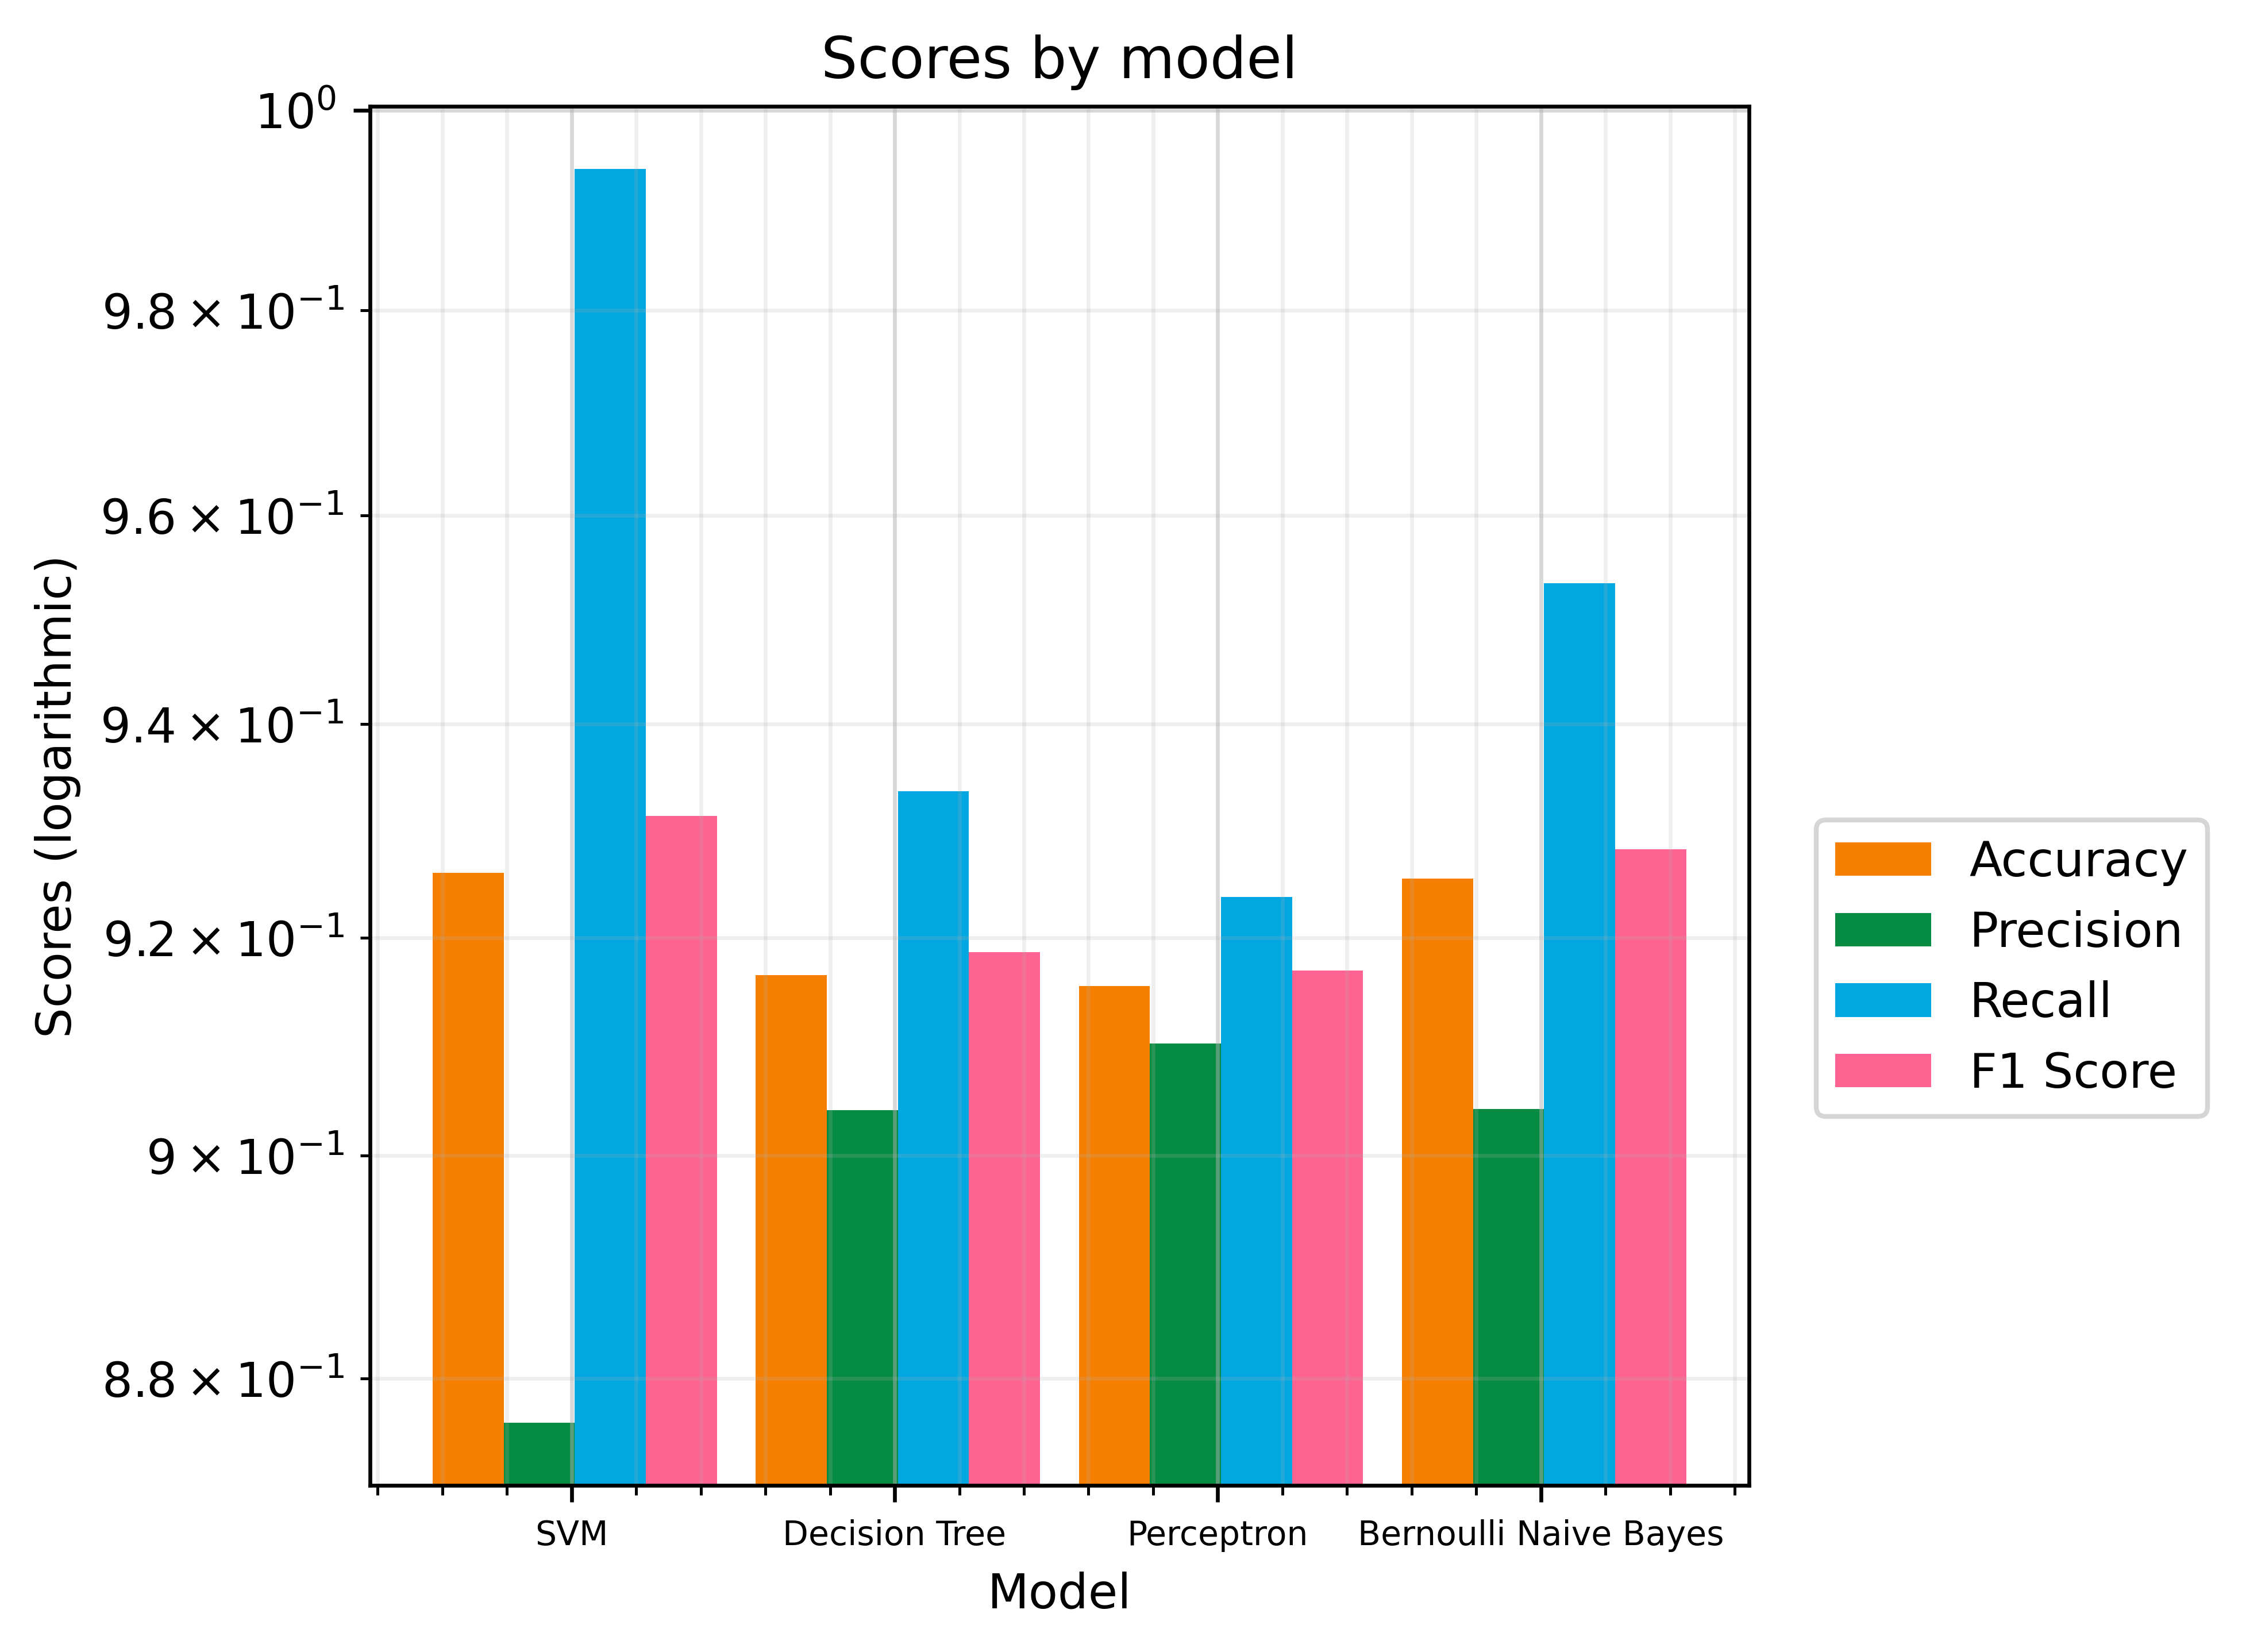

In [6]:
# create plot
fig, axes = plt.subplots(figsize = (4,4), dpi=600)


bar_width = 0.22
opacity = 0.8
ax = fig.add_axes([0,0,1,1])
index = np.arange(len(results)) + 0.1

for i, (name, scores) in enumerate(results.items()):
    
    # print(scores["accuracy"])  # sanity check
    ax.bar((i * 1) + bar_width, scores["accuracy"], color = '#F77F00', width = bar_width)
    ax.bar((i * 1) + 2 * bar_width, scores["precision"], color = '#058C42', width = bar_width)
    ax.bar((i * 1) + 3 * bar_width, scores["recall"], color = '#00A7E1', width = bar_width)
    ax.bar((i * 1) + 4 * bar_width, scores["f1"], color = '#FF6392', width = bar_width)
    

plt.xlabel('Model')
plt.ylabel('Scores (logarithmic)')
plt.title('Scores by model')

plt.xticks(index + 2 * bar_width, ('SVM', 'Decision Tree', 'Perceptron', "Bernoulli Naive Bayes"), size = 7)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1.1, 0.25)
minor_ticks = np.arange(0, 1.1, 0.1)

plt.yticks(major_ticks) # FIRST
plt.yticks(minor_ticks) # SECOND ! IMPORTANT
plt.yscale("log")  # value{"linear", "log", "symlog", "logit"

plt.minorticks_on()

plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)

plt.legend(["Accuracy", "Precision", "Recall", "F1 Score"], bbox_to_anchor=(1.35,0.5), loc = "upper right")
# plt.tight_layout()
plt.show()